In [233]:
# Configuration
geneticCode=11 # Bacterial
windowWidth=40
cdsSpan=100
utrSpan=100
randomizationDepth=10
sequenceSamplingFraction=20
cdsSeqsFilename = 'rts_export_taxid_511145_cds.fna'
utrSeqsFilename = 'rts_export_taxid_511145_3utr.fna'

In [236]:
import numpy  as np
import pandas as pd
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from codon_randomization import SynonymousCodonPermutingRandomization, NucleotidePermutationRandomization
from rnafold_vienna import RNAfold_direct


cdsRand = SynonymousCodonPermutingRandomization(geneticCode=geneticCode)
utrRand = NucleotidePermutationRandomization()

# Full length
#cdsSeq1 = 'agtggctcaacagtggtaacactggaagcacccgctacttaccacacctccgacagtggtaacacgctgatttatactgggctcaacgcgactcttttgggcacccgctcaacagtggtaacactggacttaccaggcgactgaggaggcgggggtggaggcgggggatta'
#utrSeq1 = 'ccactacgacgactgcgctacgatcgcctcgtaagatctacccagatccgacccgaccgcgctagccaacacgatcccggatggacggctcgctaggcatcgaccaccaaccaactagacgacccgactacgagggacgagggcgatgctcac'
#
#cdsSeq1 = 'agtggctcaacagtggtaacactggaagcacccgctaccgacagtggtaacacgctgatttatactgggctcaacgcgagctcaacagtggtaacactggacttaccaggcgactgatta'
#utrSeq1 = 'ccactacgacgactgcgctacgatcgcctcccacgtaagatctacccagatccggacggctcgctaggcatcgaccaccaaccaactagacgacccgactacgagggacgagggcgatgctcac'
#
#cdsSeq1 = 'agtggctcaacagtggtaacactgggtggtaataccaacgcgagctcaacagtggtaacactggacttaccaggcgactgatta'
#utrSeq1 = 'ccactacgacgactgcgctacgatcgcctcccacgtaagatctacccagatccggacggctcgctaggcatcgaccaccaaccaactagacgacccgactacgagggacgagggcgatgctcac'
#
#cdsSeq1 = 'agtggctcaacagtggtaacactgggtggtaacgcgagctcaacagtggtaacactggacttaccaggcgactgatta'
#utrSeq1 = 'ccactacgacgactgcgctacgatcgcctcccacgtaagatctacccagatccggacggctcgctaggcatcgctcgctcgcaacgcggatcgcggagctcgagtcgagtcggcgagcggctttcgatcgaccaccaaccaactagacgacccgactacgagggacgagggcgatgctcac'
#
#cdsSeq1 = 'agtggctcaacagtggtaacactggaagcacccgctacttaccacacctccgacagtggtaacacgctgatttatactgggctcaacgcgactcttttgggcacccgctcaacagtggtaacactggacttaccaggcgactgaggaggcgggggtggaggcgggggatta'
#utrSeq1 = 'ccactacgacgactgcgctacgatcgcctcgtcaccaccaaacca'
#
#cdsSeq1 = '<gtggctcaacagtggtaacactggaagcacccgctacttattaccacacctccgacagtggtaacacgctgatttatactgggctcaacgcgactcttttgggcacccgctcaacagtggtaacactggacttaccaggcgactgaggaggcaabcdefghijklmnopqrstuvwxyz'
#utrSeq1 = 'ABCDEFGHIJKLMNOPQRSTUVWXYZccactacgacgactgcgctacgatcgcctcgtaagatctacccgagatccgacccgaccgcgctagccaacacgatcccggatggacggctcgctaggcatcgaccaccaaccaactagacgacccgactacgagggacgagggcgatgctca>'
#
#cdsSeq1 = '<gggcacccgctcaacagtggtaacactggacttaccaggcgactgaggaggcaabcdefghijklmnopqrstuvwxyz'
#utrSeq1 = 'ABCDEFGHIJKLMNOPQRSTUVWXYZccactacgacgactgcgctacgatcgcctggatcgtaagatctacccagatccgacccgaccgcgctagccaa>'

def getCDSandUTRseqs(cdsfn, utrfn):
    cdsrecs = SeqIO.parse(cdsfn, "fasta", alphabet=IUPAC.unambiguous_dna)
    utrrecs = SeqIO.parse(utrfn, "fasta", alphabet=IUPAC.unambiguous_dna)
    
    for a, b in zip(cdsrecs, utrrecs):
        yield (str(a.seq), str(b.seq))
        

def makeRandomizationsForCDSand3UTR(cdsSeq, utrSeq):
    while(True):
        yield (cdsRand.randomize(cdsSeq), utrRand.randomize(utrSeq))


def getAllWindows( cdsSeq, utrSeq, windowWidth=40, cdsSpan=100, utrSpan=100):
    seq = cdsSeq + utrSeq
        
    firstWindow = len(cdsSeq) - cdsSpan
    cdsPad = 0
    if firstWindow < 0:
        cdsPad      = -firstWindow
        firstWindow = 0
    lastWindow  = min(  len(utrSeq) + utrSpan - windowWidth, utrSpan )
    utrPad = 0
    if lastWindow > len(utrSeq) - windowWidth:
        utrPad      = lastWindow - (len(utrSeq) - windowWidth)
        lastWindow  = len(utrSeq) - windowWidth
        
    if len(cdsSeq) < windowWidth:  # CDS sequence shorter than a single window
        cdsPad = cdsSpan
    if len(utrSeq) < windowWidth:  # UTR sequence shorter than a single window
        utrPad = utrSpan
        
    
    #print('cds: {} utr: {} first: {} last: {} cdspad: {} utrpad: {}'.format(len(cdsSeq), len(utrSeq), firstWindow, lastWindow, cdsPad, utrPad ))
    n = 0
    
    # padding for CDS
    for i, pos in enumerate(range(cdsPad)):
        n+=1
        yield (0, 0, 0, 0)
    
    #print('--2-- ({})'.format(n))
    # windows fully contained in CDS
    for i, pos in enumerate(range(firstWindow, len(cdsSeq)-windowWidth)):
        n+=1
        yield (pos, pos+windowWidth, 0, 0)
    
    #print('--3-- ({})'.format(n))
    # windows overlapping CDS and UTR
    for i, pos in enumerate(range(len(cdsSeq)-windowWidth, len(cdsSeq))):
        n+=1
        if i+windowWidth <= len(utrSeq):
            yield(len(cdsSeq)-windowWidth+i, len(cdsSeq), 0, i )
        
    #print('--4-- ({})'.format(n))
    # windows fully contained in UTR
    for i, pos in enumerate(range(0, lastWindow+1)):
        n+=1
        if pos+windowWidth <= len(utrSeq):
            yield(len(cdsSeq), len(cdsSeq), pos, pos+windowWidth )
    
    #print('--5-- ({})'.format(n))
    # padding for UTR
    for i, pos in enumerate(range(utrPad)):
        n+=1
        yield (0, 0, 0, 0)
        
    #print('--done-- ({})'.format(n))


def getLFEforAllWindows(cdsSeq, utrSeq, windowWidth, cdsSpan, utrSpan):
    for a in getAllWindows( cdsSeq, utrSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, utrSpan=utrSpan):
        if( a==(0,0,0,0) ): # padding
            yield( np.NAN)
            continue

        assert( (a[1]-a[0]) + (a[3]-a[2]) == windowWidth )
        seqToFold = cdsSeq[a[0]:a[1]] + utrSeq[a[2]:a[3]]
        #print("{} -> {}".format(a, len(seqToFold)))
        assert(len(seqToFold)==windowWidth)
        LFE = RNAfold_direct( seqToFold )
        yield LFE

allNativeLFEs = []
allRandomLFEs = []
allDeltaLFEs  = []

for n, seqs in enumerate(getCDSandUTRseqs( cdsSeqsFilename, utrSeqsFilename)): #[(cdsSeq1, utrSeq1), (cdsSeq1, utrSeq1), (cdsSeq1, utrSeq1)]:
    cdsSeq, utrSeq = seqs
    #print(len(cdsSeq))
    #print(len(utrSeq))
    #print(cdsSeq)
    
    if n%sequenceSamplingFraction != 0: continue   # sample a fraction of the sequences (to speed up testing)
    if len(cdsSeq) < 150: continue
    if len(utrSeq) <  80: continue
    
    #print("cds: {} utr: {}".format(len(cdsSeq), len(utrSeq)))
    
    # Calculate native LFE profile
    LFEs = []
    for LFE in getLFEforAllWindows( cdsSeq, utrSeq, windowWidth=windowWidth, cdsSpan=cdsSpan, utrSpan=utrSpan):
        LFEs.append(LFE)
    #print(len(LFEs))
    assert( len(LFEs) == cdsSpan+utrSpan+1 )
    nativeLFE = np.expand_dims( np.array(LFEs), axis=0 )
    allNativeLFEs.append(nativeLFE)

    # Calculate randomized LFE profile
    randomLFEs = []
    for n, randSeqs in enumerate( makeRandomizationsForCDSand3UTR( cdsSeq, utrSeq)):
        randCDSresult, randUTRresult = randSeqs
        randCDS = randCDSresult[2]
        randUTR = randUTRresult[2]
        #print((randCDS, randUTR))

        LFEs = []
        for LFE in getLFEforAllWindows( randCDS, randUTR, windowWidth=windowWidth, cdsSpan=cdsSpan, utrSpan=utrSpan):
            LFEs.append(LFE)
        assert(len(LFEs)==cdsSpan+utrSpan+1)
        randomLFEs.append( np.array(LFEs) )
        if n>=randomizationDepth-1: break
    randomLFEs = np.vstack(randomLFEs)
    
    allRandomLFEs.append(randomLFEs.mean(axis=0))
        


    # Calcualte delta LFE profile
    #print(nativeLFE)
    #print(np.array(randomLFEs).mean())
    #print(randomLFEs)
    #print(randomLFEs.shape)

    #print(randomLFEs.mean(axis=0))
    #print(randomLFEs.mean(axis=0).shape)

    dLFE = (nativeLFE - randomLFEs).mean(axis=0)
    allDeltaLFEs.append(dLFE)
        
    if len(allDeltaLFEs) % 20 == 19:
        print("(completed {} sequences)".format(len(allDeltaLFEs)))
        
    # DEBUG ONLY
    #if len(allDeltaLFEs) >= 5: break
    # DEBUG ONLY

nativeLFEprofile = np.vstack(allNativeLFEs).mean(axis=0)
randomLFEprofile = np.vstack(allRandomLFEs).mean(axis=0)
deltaLFEprofile  = np.vstack(allDeltaLFEs).mean(axis=0)
#print((~np.isnan(np.vstack(allNativeLFEs))).sum(axis=0))
#print((~np.isnan(np.vstack(randomLFEprofile))).sum(axis=0))
#print((~np.isnan(np.vstack(deltaLFEprofile))).sum(axis=0))



(completed 19 sequences)
(completed 39 sequences)
(completed 59 sequences)
(completed 79 sequences)


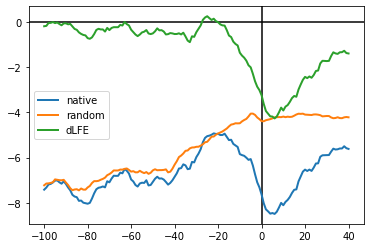

In [237]:
import matplotlib.pyplot as plt
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.plot(range(-100,101), nativeLFEprofile, lw=2, label='native')
plt.plot(range(-100,101), randomLFEprofile, lw=2, label='random')
plt.plot(range(-100,101), deltaLFEprofile,  lw=2, label='dLFE')
plt.legend();